In [1]:
%load_ext rpy2.ipython

from rpy2.robjects.packages import importr
import numpy as np
import pandas as pd
from chromax import Simulator
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
import matplotlib.gridspec as gridspec
from tqdm import tqdm
import io
from PIL import Image
import imageio
import os
os.environ["KERAS_BACKEND"] = "jax"
import matplotlib
from jax import device_get
import logging

2024-01-02 16:56:50.304682: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

def plot_means_and_variances(dataframes):
    # Calculate the mean and variance for each dataframe
    mean_values = [df.mean() for df in dataframes]
    var_values = [df.var() for df in dataframes]
    var_values = np.array(var_values).flatten()
    mean_values = np.array(mean_values).flatten()

    # Create an array for the x-values
    x_values = range(len(dataframes))

    # Create the scatter plot with error bars
    plt.errorbar(x_values, mean_values, yerr=var_values, fmt='o')

    # Display the plot
    plt.show()


def generate_genetic_map(n_markers, n_chromosomes):
  df = pd.DataFrame(generate_marker_effects(n_markers=n_markers), columns=['Yield'])
  df['cM'] = np.random.uniform(0, 200, len(df))
  df['CHR.PHYS'] = '1A'
  df = df.sort_values(by='cM')
  df = df[['CHR.PHYS', 'cM', 'Yield']]
  # save df as csv under filename
  return df

def generate_population(n_pop=100, n_markers=500):
    """
    Generate a numpy array of randoms of length 500 with randomized 0, 1, or 2 at each position.
    It will generate 100 individuals based on n_pop.

    Returns: numpy array of size (n_pop, n_markers)
    """
    shape=(n_pop, n_markers, 2)
    # Define the elements to choose from and their associated probabilities
    elements = [0, 1, 2]
    probabilities = [1/3, 1/3, 1/3]  # equal probabilities for 0, 1, and 2

    # Generate the population
    population = np.random.choice(elements, size=(n_pop, n_markers), p=probabilities)

    return np.random.choice([True, False], size=shape)


def generate_marker_effects(n_markers=500, mu=0, sigma=0.1):
    """
    Generate a numpy array of marker effects with a normal distribution.

    Parameters:
    n_markers (int): Number of markers.
    mu (float): Mean of the distribution.
    sigma (float): Standard deviation of the distribution.

    Returns:
    numpy array of marker effects
    """

    # Generate the marker effects
    marker_effects = np.random.normal(mu, sigma, n_markers)

    return marker_effects


def select_random_individuals(arr, num_individuals):
    # Get the shape of the array
    shape = arr.shape

    # Generate random indices along the first axis
    idx = np.random.choice(shape[0], size=num_individuals)

    # Select the random individuals

    return random_individuals

def select_mixed(population, random_split=.99):
  n_pop = population.shape[0]

  n_random = int(n_pop * random_split)
  n_select = int(n_pop * (1-random_split))

  random_parents = select_random_individuals(Farm.current_population, n_random)
  selected_parents = Farm.Simulator.select(Farm.current_population, k = n_select)
  combined_arr = np.concatenate((random_parents, selected_parents), axis=0)
  return combined_arr

def plot_replicate_means_and_variances(replicate_data, start_index=None, end_index=None):
    # Create a new figure and axes
    fig, ax = plt.subplots()

    # If start_index or end_index is not provided, set them to default values
    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = len(replicate_data[0])

    # For each list of dataframes in replicate_data
    for i, dataframes in enumerate(replicate_data):
        # Select the dataframes in the specified range
        dataframes = dataframes[start_index:end_index]

        # Calculate the mean and variance for each dataframe
        mean_values = [df.mean() for df in dataframes]
        var_values = [df.var() for df in dataframes]

        # Flatten the var_values and mean_values lists to 1D arrays
        var_values = np.array(var_values).flatten()
        mean_values = np.array(mean_values).flatten()

        # Create an array for the x-values
        x_values = range(len(dataframes))

        # Plot the means with error bars for the variances
        ax.errorbar(x_values, mean_values, yerr=var_values, fmt='o', label=f'Replicate {i+1}')

    # Add a legend
    ax.legend()

    # Display the plot
    plt.show()


def plot_replicate_means(replicate_data):
    # Create a new figure and axes
    fig, ax = plt.subplots()

    # For each list of dataframes in replicate_data
    for i, dataframes in enumerate(replicate_data):
        # Calculate the mean for each dataframe
        mean_values = [df.mean() for df in dataframes]
        # Flatten the mean_values list to a 1D array
        mean_values = np.array(mean_values).flatten()

        # Create an array for the x-values
        x_values = range(len(dataframes))

        # Plot the means as a line plot
        ax.plot(x_values, mean_values, label=f'Replicate {i+1}')

    # Add a legend
    ax.legend()

    # Display the plot
    plt.show()

def parse_markerEffects(genetic_map, nChr):
    # Get the length of the genetic map
    length = len(genetic_map)

    # Create a new array for storing the chromosome number for each marker
    chr = [0] * length

    # Calculate the number of markers per chromosome
    markers_per_chr = length // nChr

    # Iterate over the range of the genetic map length
    for i in range(length):
        # Calculate the chromosome number and store it in the chr array
        chr[i] = i // markers_per_chr + 1

    return chr

def score_top(scores: pd.DataFrame, column: str, k: int):
    # Sort the DataFrame from high to low
    sorted_scores = scores.sort_values(by=column, ascending=False)
    # Get the top K indexes
    top_k_indexes = sorted_scores.head(k).index
    return top_k_indexes


def score_top_percentile(scores: pd.DataFrame, column: str, percentile_min: float, percentile_max: float, k: int):
    # Ensure max percentile is greater than min percentile
    assert percentile_max > percentile_min, "Error: max percentile should be greater than min percentile"
    
    # Calculate the percentiles
    lower = scores[column].quantile(percentile_min)
    upper = scores[column].quantile(percentile_max)
    # Filter the DataFrame
    filtered_scores = scores[(scores[column] >= lower) & (scores[column] <= upper)]
    # Sample k random indexes
    sampled_indexes = np.random.choice(filtered_scores.index, k, replace=True)

    return sampled_indexes

def reshape_pop(maizeHaplo):
    reshapeHaplo = maizeHaplo.reshape(int((maizeHaplo.shape[0])/2),2,maizeHaplo.shape[1])
    reshapeHaplo = reshapeHaplo.transpose((0,2,1))
    return reshapeHaplo

def return_genetic_map_df(markerEffects, nChr, geneticMap):
    chr = parse_markerEffects(markerEffects, nChr)
    chr = [int(x[0]) for x in chr]
    trait = markerEffects
    pos = geneticMap
    # Assuming chr, trait, pos are your arrays
    df = pd.DataFrame({'CHR.PHYS': chr, 'Yield': trait, 'cM': pos})
    return df

import matplotlib.pyplot as plt

def plot_histogram(ax, probabilities, label=None, color=None):
    ax.hist(probabilities, bins='auto', density=True, alpha=0.5, label=label, color=color)
    ax.set_title('Probability Distribution')
    ax.set_xlabel('Probability')
    ax.set_ylabel('Frequency')

def plot_bar(ax, probabilities, label=None, color=None):
    indices = range(len(probabilities))
    ax.bar(indices, probabilities, alpha=0.5, label=label, color=color)
    ax.set_title('Probability per Index')
    ax.set_xlabel('Index')
    ax.set_ylabel('Probability')

def plot_probabilities(probabilities1, probabilities2):
    # Create subplots: 1 row, 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Call the plot functions for the first set of probabilities
    plot_histogram(axs[0], probabilities1, label='Probabilities 1', color='blue')
    plot_bar(axs[1], probabilities1, label='Probabilities 1', color='blue')

    # Call the plot functions for the second set of probabilities
    plot_histogram(axs[0], probabilities2, label='Probabilities 2', color='red')
    plot_bar(axs[1], probabilities2, label='Probabilities 2', color='red')

    # Add legends
    axs[0].legend(loc='upper right')
    axs[1].legend(loc='upper right')

    # Display the plots
    plt.tight_layout()  # Adjusts subplot params so that subplots fit in the figure area
    plt.show()





In [3]:
%%R
x <- seq(0, 2*pi, length.out=50)

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


In [4]:
%R -o x

In [5]:
x

array([0.        , 0.12822827, 0.25645654, 0.38468481, 0.51291309,
       0.64114136, 0.76936963, 0.8975979 , 1.02582617, 1.15405444,
       1.28228272, 1.41051099, 1.53873926, 1.66696753, 1.7951958 ,
       1.92342407, 2.05165235, 2.17988062, 2.30810889, 2.43633716,
       2.56456543, 2.6927937 , 2.82102197, 2.94925025, 3.07747852,
       3.20570679, 3.33393506, 3.46216333, 3.5903916 , 3.71861988,
       3.84684815, 3.97507642, 4.10330469, 4.23153296, 4.35976123,
       4.48798951, 4.61621778, 4.74444605, 4.87267432, 5.00090259,
       5.12913086, 5.25735913, 5.38558741, 5.51381568, 5.64204395,
       5.77027222, 5.89850049, 6.02672876, 6.15495704, 6.28318531])

In [6]:
# %R install.packages("AlphaSimR")

In [7]:
%%R
library("AlphaSimR")

Loading required package: R6


In [8]:
%%R
nInd = 10
nChr = 2
segSites = 5

founderGenomes = runMacs(nInd = nInd,
                         nChr = nChr,
                         segSites = segSites,
                         species = "MAIZE")


In [9]:
%%R
SP = SimParam$new(founderGenomes)
SP$addTraitA(segSites)
# SP$setVarE(h2=.02)
pop = newPop(founderGenomes, simParam=SP)
ans = fastRRBLUP(pop, simParam=SP, useQtl=TRUE, use='gv')
ans@gv[[1]]@addEff
markerEffects = slot(slot(ans, "gv")[[1]], "addEff")
maizeHaplo = pullSegSiteHaplo(pop)
maizeGeno = pullSegSiteGeno(pop)
#cm positions of each marker
genMap = SP$genMap
geneticMap = unlist(genMap)

In [10]:
%R -o maizeHaplo
%R -o maizeGeno
%R -o markerEffects
%R -o geneticMap
%R -o nInd
%R -o nChr
%R -o segSites

In [11]:
nMarkers = segSites * nChr

In [12]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape


import random

import random

def simplify_geneticmap(lst, qtl):
    # Select 'qtl' random indexes
    indexes_positive = random.sample(range(len(lst)), qtl)
    
    # Select 'qtl' random indexes not already selected
    remaining_indexes = set(range(len(lst))) - set(indexes_positive)
    indexes_negative = random.sample(remaining_indexes, qtl)

    # Modify the list
    for i in range(len(lst)):
        if i in indexes_positive:
            lst[i] = random.uniform(0.5, 1.0)  # Assign random float between 0.5 and 1.0
        elif i in indexes_negative:
            lst[i] = random.uniform(-0.5, -1.0)  # Assign random float between -0.5 and -1.0
        else:
            lst[i] = 0  # Assign 0

    return lst



import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_data(file_path):
    """
    Load the numpy array from the specified file path.
    """
    return np.load(file_path)

def sum_ploidy_values(data):
    """
    Sum the ploidy values in the data.
    """
    return np.sum(data, axis=2)

def create_heatmap(data, title="Heatmap of Ploidy Values", xlabel="Marker Index", ylabel="Individual Index"):
    """
    Create a heatmap from the provided data.
    """
    # Choosing a visually appealing color scheme
    cmap = sns.color_palette(["#1f77b4", "#ff7f0e", "#2ca02c"], as_cmap=True)

    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(data, cmap=cmap, cbar=False)

    # Creating a color bar manually
    cbar = ax.figure.colorbar(ax.collections[0])
    cbar.set_ticks([0.33, 1, 1.67])
    cbar.set_ticklabels(['0', '1', '2'])
    cbar.set_label('Summed Ploidy Value')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

In [13]:
def plot_population_heatmap(ax, population_data, marker_strength):
    summed_data = np.sum(population_data, axis=2)
    cmap = sns.color_palette(["#1f77b4", "#ff7f0e", "#2ca02c"])
    strength_cmap = matplotlib.colormaps.get_cmap('RdYlGn')  # Updated line
    sns.heatmap(summed_data, cmap=cmap, cbar_kws={'ticks': [0, 1, 2]}, ax=ax)

    ax.set_xticks(np.arange(population_data.shape[1]) + 0.5)
    marker_labels = [f'{i+1}' for i in range(population_data.shape[1])]
    ax.set_xticklabels(marker_labels, rotation=0, ha='center')

    for tick_label, strength in zip(ax.get_xticklabels(), marker_strength):
        tick_label.set_backgroundcolor(strength_cmap((strength + 1) / 2))  # Normalize and map the strength value
        tick_label.set_color('white')
        tick_label.set_fontweight('bold')
        tick_label.set_bbox(dict(facecolor=strength_cmap((strength + 1) / 2), edgecolor='none', boxstyle='round,pad=0.3'))

    ax.set_title("Heatmap of Population Genotype Dosages")
    ax.set_xlabel("Markers")
    ax.set_ylabel("Individuals")

def plot_allele_frequencies(ax, data, marker_strength, sort_by_allele_0=False, bar_width=0.8):
    allele_counts = np.apply_along_axis(lambda x: np.bincount(x, minlength=3), axis=2, arr=data)
    total_allele_counts = allele_counts.sum(axis=0)
    allele_frequencies = total_allele_counts / total_allele_counts.sum(axis=1)[:, np.newaxis]

    allele_0_proportions = allele_frequencies[:, 0]
    allele_1_proportions = allele_frequencies[:, 1]
    x_positions = np.arange(1, len(allele_0_proportions) + 1)
    normalized_strength = (np.array(marker_strength) + 1) / 2

    cmap = plt.cm.RdYlGn

    if sort_by_allele_0:
        sorted_indices = np.argsort(-allele_0_proportions)
        allele_0_proportions = allele_0_proportions[sorted_indices]
        allele_1_proportions = allele_1_proportions[sorted_indices]
        normalized_strength = normalized_strength[sorted_indices]

    for xpos, a0, a1, strength in zip(x_positions, allele_0_proportions, allele_1_proportions, normalized_strength):
        ax.bar(xpos, a0, color='red', edgecolor='black', width=bar_width, label='Allele 0' if xpos == 1 else "")
        ax.bar(xpos, a1, bottom=a0, color='black', edgecolor='black', width=bar_width, label='Allele 1' if xpos == 1 else "")
        ax.text(xpos, -0.05, f'{xpos}', horizontalalignment='center', verticalalignment='center', 
                 color='white', fontsize=8, fontweight='bold', 
                 bbox=dict(facecolor=cmap(strength), edgecolor='none', boxstyle='round,pad=0.2'))

    ax.set_ylim(-0.15, 1)
    ax.set_ylabel('Proportion')
    ax.set_xlabel('Marker Position')
    ax.set_title('Proportion of Alleles 0 and 1 at Each Marker' + (' (Sorted by Allele 0)' if sort_by_allele_0 else ''))
    ax.legend(loc='upper right')

import tempfile
import os

def create_frame(farm, episode):
    temp_dir = farm.temp_dir
    fig = plt.figure(figsize=(10, 15))  # Adjust the figure size

    gs = gridspec.GridSpec(3, 1, figure=fig)

    ax1 = fig.add_subplot(gs[0])
    farm.view_policy(ax1, episode)

    ax2 = fig.add_subplot(gs[1])
    plot_population_heatmap(ax2, self.current_population, self.marker_strength)

    ax3 = fig.add_subplot(gs[2])
    plot_allele_frequencies(ax3, self.current_population, self.marker_strength)

    # Save the figure as a png in the temporary directory
    filename = os.path.join(temp_dir.name, f'frame_{episode}.png')
    plt.savefig(filename)
    plt.close(fig)  # Close the plot

    return filename  # Return the filename for future use
def select_parents(policy):
    # Calculate the number of top elements to select.
    k = policy.shape[1] // 2
    # If the tensor has an odd number of elements, add one to 'k' to get the upper half.
    if policy.shape[1] % 2 != 0:
        k += 1
    values, indices = tf.math.top_k(policy, k)
    return values,indices


In [25]:
#VISUALIZATIONS



#average fitness for each episode
import matplotlib.pyplot as plt
import pandas as pd


def truncate_cycle(x):
    nInd = x.current_population.shape[0]
    top5 = x.simulator.select(x.current_population,k=nInd // 2)
    new_pop = x.simulator.random_crosses(top5,n_crosses=nInd)
    x.history.append(x.simulator.GEBV(new_pop))
    x.current_population = new_pop


def baseline_plot():
    total_cycles = 20
    trunk_farm = farm
    for i in range(total_cycles):
        truncate_cycle(trunk_farm)

    data = [x.to_numpy().flatten() for x in trunk_farm.history]
    df = pd.DataFrame(data).T

    plt.figure(figsize=(12, 6))  # Optional: You can set the figure size
    sns.boxplot(data=df)

    plt.title('Baseline Heuristic')  # Add title
    plt.xlabel('Episode Number')  # Add x-axis label

    plt.show()

def plot_initial_population_policy_tracker_updated(dataset, indices, true_values, ax=None):
    def top_50_percent_indices(array):
        """Helper function to find the top 50% indices of an array."""
        threshold = np.percentile(array, 50)
        return np.where(array > threshold)

    # Plotting
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))  # Create a new figure and axes if none is provided

    # Preparing the data for imshow - adding the 'true_values' as the first column
    data_for_plotting = np.column_stack([true_values.squeeze()] + [d.squeeze() for d in dataset])

    # Displaying the arrays as columns with appropriate coloring
    ax.imshow(data_for_plotting, aspect='auto', cmap=plt.cm.viridis)

    # Adding red rectangles for top 50% values in each array, including 'true_values'
    all_data = [true_values] + dataset
    for i, array in enumerate(all_data):
        top_indices = top_50_percent_indices(array.squeeze())
        for index in top_indices[0]:
            rect = plt.Rectangle((i-0.5, index-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3)
            ax.add_patch(rect)

    # Setting the axis labels and title
    ax.set_xlabel("Episode Number")
    ax.set_ylabel("Individual ID")

    # Setting x-axis tick labels to include 'Truth' for the first column and sampled indices for the rest
    tick_labels = ['Truncation'] + [f"{idx+1}" for idx in indices]
    plt.xticks(range(len(all_data)), tick_labels)

    plt.yticks(range(len(true_values.squeeze())), range(len(true_values.squeeze())))

    # Adding grid lines
    ax.grid(True, which='both', axis='both', linestyle='-', color='lightgrey', linewidth=0.5)

    ax.set_title("Initial Population Policy Tracker")
    
    return ax




def sample_dataset_by_percentile(dataset, percentile):
    """
    Samples a dataset based on a given percentile and returns the sampled data along with their original indices.

    :param dataset: List or array-like structure containing the dataset.
    :param percentile: The percentile step to use for sampling (e.g., 10 for 10th percentile steps).

    :return: A tuple containing two lists - the sampled dataset and their corresponding indices.
    """
    if not 0 < percentile <= 100:
        raise ValueError("Percentile must be between 0 and 100")

    num_elements = len(dataset)
    step = int(num_elements * (percentile / 100))
    
    # Handle the case where step size is 0 due to a very small dataset
    if step == 0:
        step = 1

    # Sampling indices
    sampled_indices = range(0, num_elements, step)

    # Sampling the dataset
    sampled_dataset = [dataset[i] for i in sampled_indices]

    return sampled_dataset, list(sampled_indices)

def baseline_plot(ax=None):
    total_cycles = 20
    trunk_farm = farm
    for i in range(total_cycles):
        truncate_cycle(trunk_farm)

    data = [x.to_numpy().flatten() for x in trunk_farm.history]
    df = pd.DataFrame(data).T

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))  # Create a new figure and axes if none is provided

    sns.boxplot(data=df, ax=ax)

    ax.set_title('Baseline Heuristic')  # Add title
    ax.set_xlabel('Episode Number')  # Add x-axis label

    return ax



def fitness_plot(ax=None):
    mean_score_list = [x.mean() for x in farm.fitness_history]
    mean_score_series = pd.Series(mean_score_list)

    # Calculate the rolling average
    rolling_mean = mean_score_series.rolling(window=100).mean()

    # Create the plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))  # Create a new figure and axes if none is provided

    ax.plot(mean_score_series, label='Original')
    ax.plot(rolling_mean, 'r-', label='Rolling Average')
    ax.set_title("population_fitness (higher is better)")
    ax.legend(loc='upper left')

    return ax

# Example usage:
# sampled_data, sampled_indices  = sample_dataset_by_percentile(farm.fitness_history, 10)
# plot_initial_population_policy_tracker_updated(sampled_data, sampled_indices, farm.simulator.GEBV(farm.initial_population) )

# baseline_plot()

# fitness_plot()

import psutil
import os

# Function to convert large number of bytes into a human readable format
def bytes_to_human(n):
    symbols = ('K', 'M', 'G', 'T', 'P', 'E', 'Z', 'Y')
    prefix = {}
    for i, s in enumerate(symbols):
        prefix[s] = 1 << (i + 1) * 10
    for s in reversed(symbols):
        if n >= prefix[s]:
            value = float(n) / prefix[s]
            return '%.1f%s' % (value, s)
    return "%sB" % n

# Function to print out memory usage
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Memory usage: {bytes_to_human(process.memory_info().rss)}")
    return float(bytes_to_human(process.memory_info().rss)[:-1])

# Print out memory usage at the start
print_memory_usage()

# Your code here...
# ...

# Print out memory usage at the end
print_memory_usage()



def policy2offspring_reward(policy, current_population, simulator):
    parent_values, parent_indices = select_parents(policy)
    selected_parents = current_population[parent_indices.numpy()]
    new_pop = simulator.random_crosses(selected_parents[0], n_crosses = selected_parents[0].shape[0] * 2)
    reward = simulator.GEBV(new_pop).mean()[0] - simulator.GEBV(current_population).mean()[0]
    return new_pop, reward

# policy = actor_output
# current_population = population_dummy
# simulator = simulator
# newpop, reward  = policy2offspring_reward(policy, current_population, simulator)


def add_batchdim(arr):
    return np.expand_dims(arr, axis=0)


Memory usage: 826.5M
Memory usage: 826.5M


In [26]:
import numpy as np
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
from tensorflow.keras import Model
import tensorflow as tf

def create_critic(n, m, d, population_dummy, scores_dummy, output_dummy):
    # Create an additional input for the scores and actor's output
    score_input = tf.keras.layers.Input(shape=(n,))
    actor_output_input = tf.keras.layers.Input(shape=output_dummy.shape[1:])

    # Define the critic model
    critic_input = tf.keras.layers.Input(shape=(n, m, d))

    x1 = Flatten()(critic_input)
    x2 = Dense(64, activation='relu')(score_input)  # Dense layer for the scores
    x3 = Flatten()(actor_output_input)  # Flatten the actor's output
    x = tf.keras.layers.Concatenate()([x1, x2, x3])  # Concatenate the flattened critic input, score input, and actor's output
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(1, activation='linear')(x)  # Output layer with single linear unit

    critic_model = tf.keras.models.Model([critic_input, score_input, actor_output_input], x)
    critic_model.compile(optimizer='adam', loss='mean_squared_error')  # Use MSE loss for value prediction

    return critic_model

def create_actor(n, m, d, total_parents, population_dummy, scores_dummy):
    # Create an additional input for the scores
    score_input = tf.keras.layers.Input(shape=(n,))

    # Define the actor model
    actor_input = tf.keras.layers.Input(shape=(n, m, d))

    x1 = Flatten()(actor_input)
    x2 = Dense(64, activation='relu')(score_input)  # Dense layer for the scores
    x = tf.keras.layers.Concatenate()([x1, x2])  # Concatenate the flattened actor input and the score input
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(n, activation='relu')(x)  # Output layer with n linear units

    actor_model = tf.keras.models.Model([actor_input, score_input], x)
    actor_model.compile(optimizer='adam', loss='mean_squared_error')  # Use MSE loss for value prediction

    return actor_model



#dummy functions to  generate fake data to develop the training pipeline
def pop_gen(b, n, m, d):
    return np.random.randint(2, size=(b, n, m, d))
def reward_gen():
    return np.random.rand
def scores_gen(n):
    return np.random.rand(1, n)



genetic_map = return_genetic_map_df(markerEffects, nChr, geneticMap)
genetic_map['Yield'] = simplify_geneticmap(list(genetic_map['Yield']),4)

n = int(nInd[0])
m = int(nMarkers)
d = 2
total_parents = n*2

population_dummy = pop_gen(1, n, m, d)  # Extra dimension for batch size
scores_dummy =  scores_gen(n) # Extra dimension for batch size

actor_model = create_actor(n,m,d,total_parents, population_dummy, scores_dummy)
actor_output = actor_model([population_dummy, scores_dummy])
critic_model = create_critic(n,m,d, population_dummy, scores_dummy,actor_output)

simulator = Simulator(genetic_map=genetic_map, h2=.5)
simulator.load_population('mypop.npy')
initial_scores = simulator.GEBV(population_dummy[0])

TOTAL_EPISODES=3
before = print_memory_usage()
for episodes in range(TOTAL_EPISODES):
    inputs = tf.random.normal([1, n, m, d]) # replace with actual inputs
    scores_dummy = tf.random.normal([1, n]) # replace with actual scores
    #policy, current_population, simulator
    new_pop,reward = policy2offspring_reward(actor_output, population_dummy, simulator)
    train_step(actor_model, critic_model, inputs, scores_dummy, reward)
    tf.keras.backend.clear_session()
after = print_memory_usage()

print(f'cost per episode: {( after - before ) / TOTAL_EPISODES}')

Memory usage: 826.5M


IndexError: index 2 is out of bounds for axis 0 with size 1

In [40]:
class BreedingProgram:
    """
    Represents a breeding program with a PPO agent.
    """

    def __init__(self, initial_population, genetic_map, population_size, marker_count, chromosome_number, max_generation, heritability):
        """
        Initializes the breeding program.
        """

        # Initialize the basic attributes
        self.population_size = population_size
        self.marker_count = marker_count
        self.initial_population = initial_population
        self.genetic_map = genetic_map
        self.max_generation = max_generation
        self.marker_strength = np.array(self.genetic_map['Yield'])

        # Initialize the simulator
        self.simulator = Simulator(genetic_map=self.genetic_map, h2=heritability)
        self.simulator.load_population('mypop.npy')
        self.initial_scores = self.simulator.GEBV(self.initial_population)

        #tempdir
        self.temp_dir = tempfile.TemporaryDirectory()

#actor_model = create_actor(n,m,d,total_parents, population_dummy, scores_dummy)

        # Initialize the current generation and history
        self.current_generation = 0
        self.history = []

        # Initialize the Actor and Critic models
        #actor_model = create_actor(n,m,d,total_parents, population_dummy, scores_dummy)

        self.actor = create_actor(n=self.population_size,
                                  m=self.marker_count,
                                  d=2,
                                  total_parents = self.population_size,
                                  population_dummy = self.initial_population, 
                                  scores_dummy=self.simulator.phenotype(self.initial_population)
                                  )
        population_dummy = np.random.rand(1, self.population_size,self.marker_count,2)  # Extra dimension for batch size
        scores_dummy = np.random.rand(1, self.population_size)  # Extra dimension for batch size
        output_dummy = self.actor([population_dummy, scores_dummy])
        self.critic = create_critic(n=self.population_size,
                                  m=self.marker_count,
                                  d=2,
                                  population_dummy = self.initial_population, 
                                  scores_dummy=self.simulator.phenotype(self.initial_population),
                                  output_dummy = output_dummy)
        

        # self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
        # self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
        # self.critic_history = []
        # self.actor_history = []
        # self.reward_history = []
        # self.fitness_history = []
        # self.snapshot_history = []

                # Start the breeding program
        self._start_breeding_program()
        
    def _start_breeding_program(self):
        """
        Starts the breeding program.
        """
        self.current_population = self.initial_population
        self.current_scores = self.simulator.GEBV(self.initial_population)
        self.history.append(self.current_scores)
        self.agent_history = []
        # self.snapshot_history.append(self.actor([self.initial_population.reshape(1, *self.initial_population.shape), self.initial_scores.to_numpy().transpose()], training=True).numpy())

    # USE AGENT
    def agent_select(self,population):
        """
        used to test the existing agent given a population (n,m,d)
        """
        # Prepare inputs for actor model
        current_pop = device_get(population.reshape(1, *population.shape))
        current_scores = self.simulator.phenotype(current_pop[0])
        current_scores = current_scores.to_numpy().transpose()

        # Get policy and select parents
        policy = self.actor([current_pop, current_scores])

        return policy
    
    # TRAINING 
    @tf.function
    def train_step(self, inputs, scores_dummy,reward):
        with tf.GradientTape() as actor_tape, tf.GradientTape() as critic_tape:
            actor_output = self.actor([inputs, scores_dummy], training=True)
            critic_value = self.critic([inputs, scores_dummy, actor_output], training=True)
            actor_loss = -tf.reduce_mean(critic_value)
            critic_loss = tf.keras.losses.MSE(reward, critic_value)
        
        actor_grads = actor_tape.gradient(actor_loss, self.actor.trainable_variables)
        critic_grads = critic_tape.gradient(critic_loss, self.critic.trainable_variables)
        
        self.actor.optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))
        self.critic.optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))

    def run_single(self):
        # before = print_memory_usage()
        inputs = add_batchdim(self.current_population)
        scores_dummy = np.array(self.current_scores.transpose())
        actor_output = actor_model([inputs, scores_dummy])
        new_pop,reward = policy2offspring_reward(actor_output, self.current_population, self.simulator)
        self.train_step(inputs, scores_dummy, reward)
        # tf.keras.backend.clear_session()
        self.current_population = new_pop
        self.current_scores = self.simulator.GEBV(new_pop)
        # after = print_memory_usage()
        return reward, self.current_scores


initial_population =  reshape_pop(maizeHaplo) 
genetic_map = return_genetic_map_df(markerEffects, nChr, geneticMap)
genetic_map['Yield'] = simplify_geneticmap(list(genetic_map['Yield']),4)
reshapeHaplo = reshape_pop(maizeHaplo)
np.save('mypop', reshapeHaplo)
print(f'reshape haplo {reshapeHaplo.shape}')
population_size = int(nInd)
marker_count = int((segSites * nChr))
chromosome_number = int(nChr)
max_generation = 10
heritability = .95
mean_score_list=[]
critic_loss_list=[]

farm  = BreedingProgram(initial_population, genetic_map, population_size, marker_count, chromosome_number, max_generation, heritability)

reshape haplo (10, 10, 2)


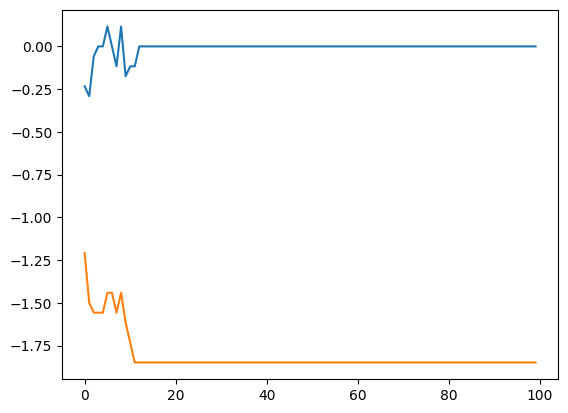

In [42]:

rewards = []
scores = []
for _ in range(100):
    reward, score = farm.run_single()
    rewards.append(reward)
    scores.append(score)
plt.plot(rewards)
plt.plot([x.mean() for x in scores])
plt.show()

In [ ]:
gs = gridspec.GridSpec(1, 1)

# Prepare pandas Series for rolling averages
critic_history = pd.Series(rewards)
# Calculate rolling averages
critic_history_avg = critic_history.rolling(window=100).mean()
# Add existing plots on the top row
ax1 = plt.subplot(gs[0, 0])
ax1.plot(critic_history, label='Original')
ax1.plot(critic_history_avg, 'r-', label='Rolling Average')
ax1.set_title('reward- per step')
ax1.legend(loc='upper left')
ax1.tick_params(labelbottom=False)  # Hide x-axis label

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd

window_size = 2


# Create a 4x3 grid
fig = plt.figure(figsize=(15, 20))
gs = gridspec.GridSpec(4, 3)

# Prepare pandas Series for rolling averages
critic_history = pd.Series(farm.critic_history)
actor_history = pd.Series(farm.actor_history)
reward_history = pd.Series(farm.reward_history)

# Calculate rolling averages
critic_history_avg = critic_history.rolling(window=window_size).mean()
actor_history_avg = actor_history.rolling(window=window_size).mean()
reward_history_avg = reward_history.rolling(window=window_size).mean()

# Add existing plots on the top row
ax1 = plt.subplot(gs[0, 0])
ax1.plot(critic_history, label='Original')
ax1.plot(critic_history_avg, 'r-', label='Rolling Average')
ax1.set_title('Critic Loss History - per step')
ax1.legend(loc='upper left')
ax1.tick_params(labelbottom=False)  # Hide x-axis label

ax2 = plt.subplot(gs[0, 1])
ax2.plot(actor_history, label='Original')
ax2.plot(actor_history_avg, 'r-', label='Rolling Average')
ax2.set_title('Actor Loss History - per step')
ax2.legend(loc='upper left')
ax2.tick_params(labelbottom=False)  # Hide x-axis label

ax3 = plt.subplot(gs[0, 2])
ax3.plot(reward_history, label='Original')
ax3.plot(reward_history_avg, 'r-', label='Rolling Average')
ax3.set_title('Reward History - per step')
ax3.legend(loc='upper left')
ax3.tick_params(labelbottom=False)  # Hide x-axis label

# Add fitness_plot on the second row
ax4 = plt.subplot(gs[1, :])
fitness_plot(ax4)

# Add plot_initial_population_policy_tracker_updated on the third row
ax5 = plt.subplot(gs[2, :])
sampled_data, sampled_indices = sample_dataset_by_percentile(farm.fitness_history, 10)
plot_initial_population_policy_tracker_updated(sampled_data, sampled_indices, farm.simulator.GEBV(farm.initial_population), ax5)

# Add baseline_plot on the fourth row
ax6 = plt.subplot(gs[3, :])
baseline_plot(ax6)

# Adjust the space between rows
plt.subplots_adjust(hspace=0.5)

# Display the figure with the subplots
plt.show()
